# **Sprint 2**


**Atividade: Implementação de algoritmo para tratamento das estruturas de dados**

In [19]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

In [20]:
# Caminho para o diretório contendo os arquivos Excel
path = '/home/coldrand/pyTBI-data/data/TBI_experiment/15min'

# Glob para obter todos os arquivos Excel no diretório
all_files = glob.glob(path + "/*.xlsx")

# Inicializando uma lista vazia para armazenar os dataframes
dfs = []

# Limite de 2400 pontos
num_points = 2400

# Índice de tempo consistente (intervalos de 15 minutos)
time_index = pd.date_range("00:00", periods=num_points, freq="15T")

# Percorrer a lista de arquivos e leia cada um em um dataframe
for file in all_files:
    df = pd.read_excel(file, parse_dates=['date_time'])
    df.set_index('date_time', inplace=True)
    dfs.append(df['temp'])  # Only select the 'temp' column


/tmp/ipykernel_18546/4259748337.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_index = pd.date_range("00:00", periods=num_points, freq="15T")


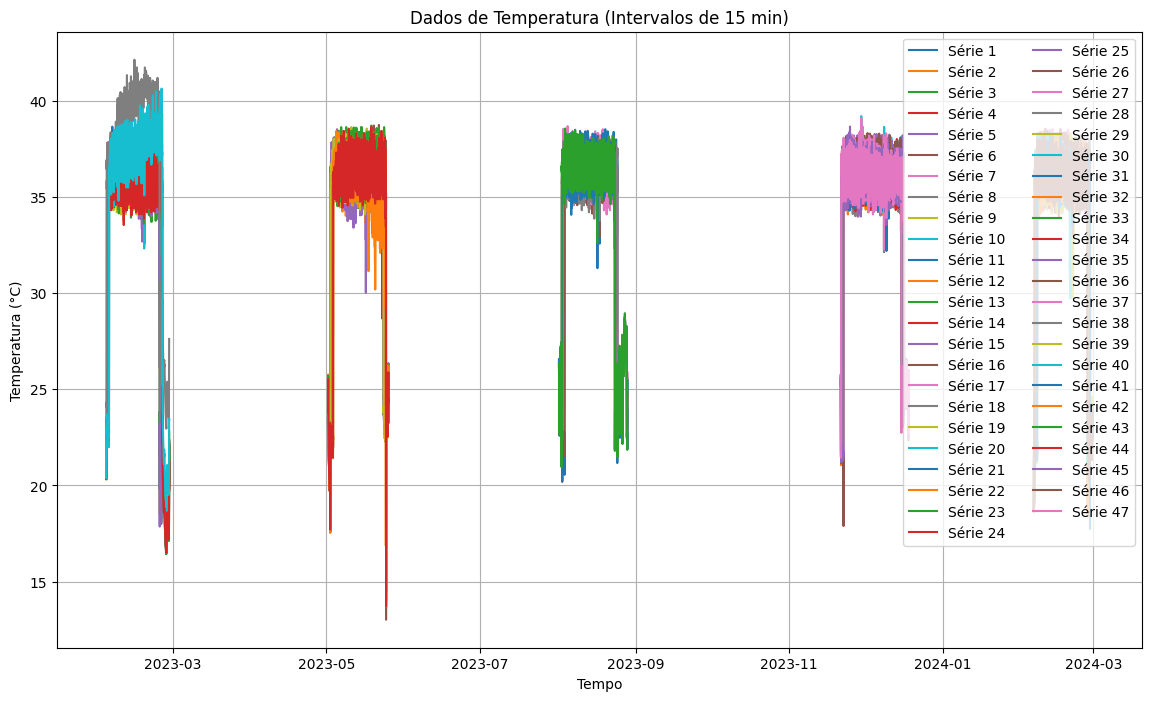

In [21]:
# Concatenar os dataframes em um único ao longo das colunas
combined_df = pd.concat(dfs, axis=1)

combined_df.columns = [f'Série {i+1}' for i in range(len(combined_df.columns))]

plt.figure(figsize=(14, 8))

for i in range(len(combined_df.columns)):
    plt.plot(combined_df.index, combined_df.iloc[:, i], label=f'Série {i+1}')

plt.title('Dados de Temperatura (Intervalos de 15 min)')
plt.xlabel('Tempo')
plt.ylabel('Temperatura (°C)')
plt.legend(loc='upper right', ncol=2) 
plt.grid(True)
plt.show()

# Atividade: Modelagem Circadiana com Cosinor

### Durante a conversa com os pesquisadores, foi apresentado um artigo que discute a aplicação do modelo Cosinor em um framework de efeitos mistos para analisar ritmos circadianos. Embora focado no R com cosinoRmixedeffects, sugeriu-se a aplicação em Python usando scipy e statsmodels para modelar dados de temperatura de ratos, ajustando parâmetros como MESOR, amplitude e acrofase.

In [22]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

In [23]:
# Carregando os metadados
metadata = pd.read_csv('/home/coldrand/pyTBI-data/data/TBI_experiment/metadata.csv')

# Folder path
folder_path = '/home/coldrand/pyTBI-data/data/TBI_experiment/15min/'

# Use glob to get all xlsx files in the folder
file_paths = glob.glob(os.path.join(folder_path, '*.xlsx'))

# Dictionary to store dataframes
dataframes = {}

# Read each file into a DataFrame and attribute it based on the last digits
for path in file_paths:
    # Extract the last digits from the file name (assuming the last underscore and after)
    file_name = os.path.basename(path)  # Extracts 'brunaX_Y.xlsx'
    identifier = file_name.split('_')[-1].replace('.xlsx', '')  # Extracts 'Y'
    
    # Read the file into a pandas DataFrame
    df = pd.read_excel(path)
    
    # Store the DataFrame in the dictionary using the identifier
    dataframes[identifier] = df

# Define the animals and experiments you're interested in
animals = range(1, 11)  # 1 through 10
experiments = [3, 4, 5, 7, 8]

# Prepare a nested dictionary to store dataframes for each animal and experiment
temperature_data = {animal: {} for animal in animals}

# Iterate over each animal and experiment to load the corresponding files
for animal in animals:
    for exp in experiments:
        # Construct the file name
        file_name = f'bruna{animal}_{exp}.xlsx'
        file_path = os.path.join(folder_path, file_name)
        
        # Check if the file exists before attempting to load
        if os.path.exists(file_path):
            # Read the file into a pandas DataFrame
            df = pd.read_excel(file_path)
            # Store the DataFrame in the nested dictionary
            temperature_data[animal][exp] = df

# Example access to the data:
# To access the DataFrame for animal 3 and experiment 7:
df_animal3_exp7 = temperature_data[3][7]

# Display the first few rows of the dataframe
print(df_animal3_exp7.head())

            date_time   temp
0 2023-11-26 01:00:00  35.43
1 2023-11-26 01:15:00  35.87
2 2023-11-26 01:30:00  35.90
3 2023-11-26 01:45:00  36.12
4 2023-11-26 02:00:00  36.09


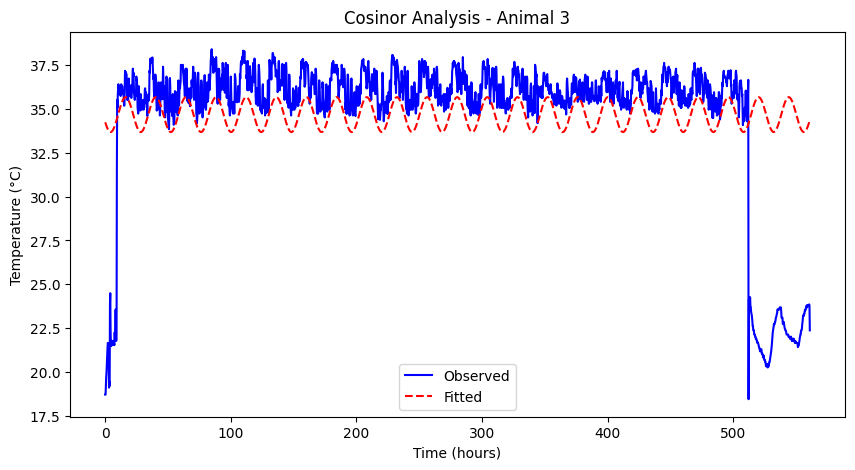

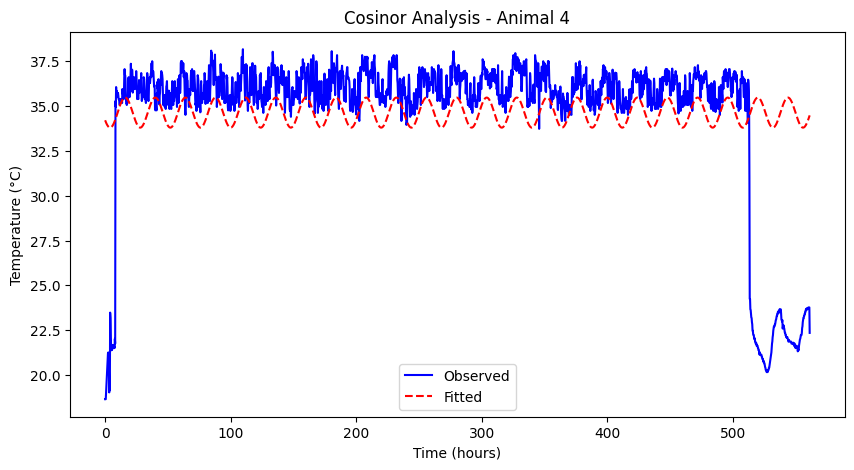

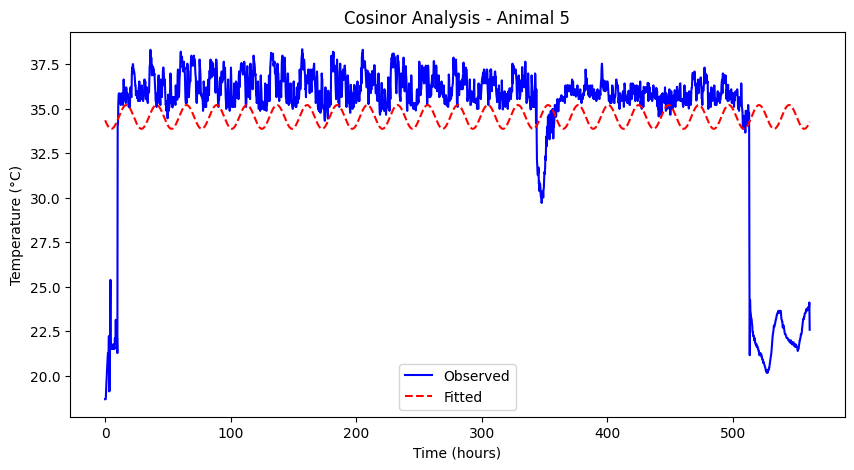

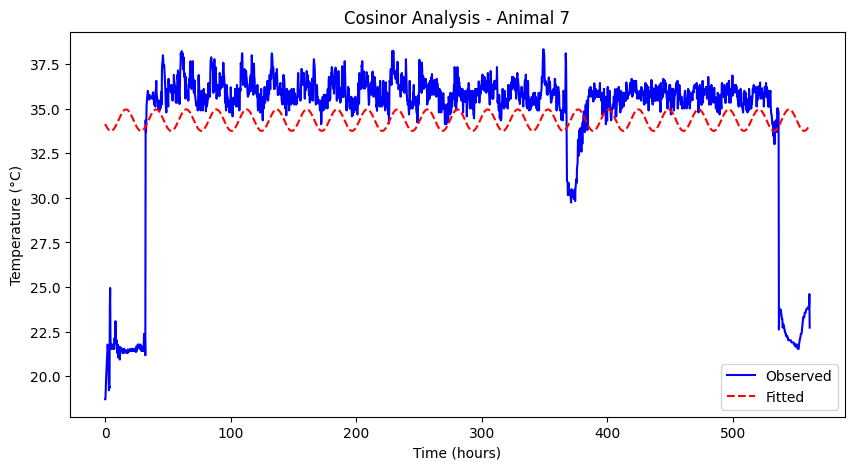

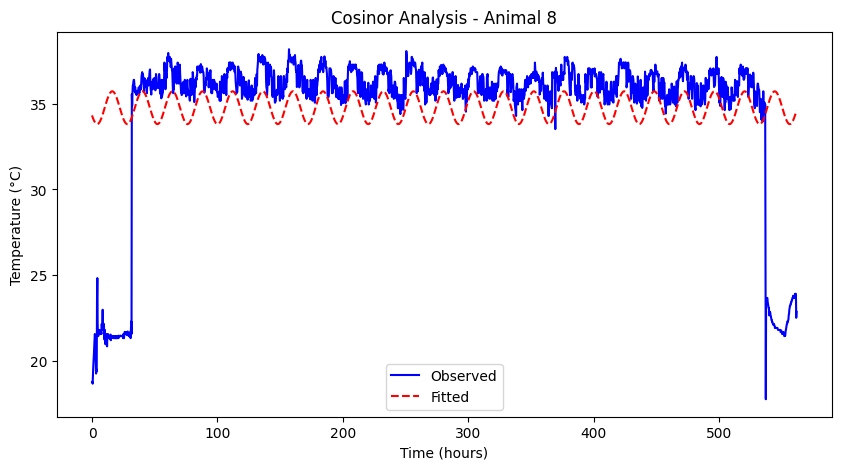

TBI Results: {3: {'Mesor': np.float64(34.679603346637876), 'Amplitude': np.float64(-0.9953527593888591), 'Acrophase': np.float64(1.1121764359146935)}, 4: {'Mesor': np.float64(34.635230722243904), 'Amplitude': np.float64(-0.8385413699841946), 'Acrophase': np.float64(1.0359297039799278)}, 5: {'Mesor': np.float64(34.538567617045075), 'Amplitude': np.float64(-0.6673063888588602), 'Acrophase': np.float64(1.2826459090923295)}}
Sham Results: {7: {'Mesor': np.float64(34.34784332160441), 'Amplitude': np.float64(-0.6032275536292137), 'Acrophase': np.float64(1.2058301517962493)}, 8: {'Mesor': np.float64(34.78140395512656), 'Amplitude': np.float64(-0.9588081476180286), 'Acrophase': np.float64(1.081422840914778)}}


In [24]:
# Cosinor model function
def cosinor_model(time, mesor, amplitude, acrophase):
    return mesor + amplitude * np.cos((2 * np.pi * time / 24) - acrophase)

# Perform Cosinor Analysis
def perform_cosinor_analysis(group_data):
    results = {}
    for animal, data in group_data.items():
        # Ensure data is in 15-minute intervals
        data['time'] = pd.to_datetime(data['date_time'])  # Convert to datetime if not already
        time_in_minutes = (data['time'] - data['time'].min()).dt.total_seconds() / 60  # Convert time to minutes
        time_in_hours = time_in_minutes / 60  # Convert time to hours

        temperature = data['temp'].values

        # Initial guess for [mesor, amplitude, acrophase]
        guess = [temperature.mean(), (temperature.max() - temperature.min()) / 2, 0]

        # Fitting
        try:
            params, _ = curve_fit(cosinor_model, time_in_hours, temperature, p0=guess)
            mesor, amplitude, acrophase = params

            results[animal] = {
                'Mesor': mesor,
                'Amplitude': amplitude,
                'Acrophase': acrophase
            }

            # Plotting the figure
            fitted_temp = cosinor_model(time_in_hours, *params)
            plt.figure(figsize=(10, 5))
            plt.plot(time_in_hours, temperature, 'b-', label='Observed')
            plt.plot(time_in_hours, fitted_temp, 'r--', label='Fitted')
            plt.title(f'Cosinor Analysis - Animal {animal}')
            plt.xlabel('Time (hours)')
            plt.ylabel('Temperature (°C)')
            plt.legend()
            plt.show()

        except RuntimeError as e:
            print(f"Curve fitting failed for animal {animal}: {e}")
            continue

    return results

# Assuming temperature_data is the dictionary containing all loaded DataFrames
# Separate the analysis for TBI and Sham groups
# Replace these with actual group-specific data in your real use case

# For example, let's assume:
# TBI group: animals 3, 4, 5 (just an example, replace with actual group logic)
# Sham group: animals 7, 8 (just an example, replace with actual group logic)

tbi_group_data = {animal: temperature_data[animal][exp] for animal in [3, 4, 5] for exp in [7, 8] if exp in temperature_data[animal]}
sham_group_data = {animal: temperature_data[animal][exp] for animal in [7, 8] for exp in [7, 8] if exp in temperature_data[animal]}

# Perform Cosinor analysis on TBI group
tbi_results = perform_cosinor_analysis(tbi_group_data)

# Perform Cosinor analysis on Sham group
sham_results = perform_cosinor_analysis(sham_group_data)

# Displaying the results
print("TBI Results:", tbi_results)
print("Sham Results:", sham_results)
